In [1]:
import pandas as pd
import glob
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import numpy as np
# https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees

### Loading  Data

In [2]:
train_data = pd.read_csv("C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Feb 18th\\summary_card\\df_train_summary.csv")
test_data = pd.read_csv("C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Feb 18th\\summary_card\\df_test_summary.csv")

In [3]:
print(train_data.shape)
test_data.shape

(201917, 95)


(123623, 93)

### Functions to concatenate features, kfold splits

In [4]:
def feature_concat(train_data1,filepath):
    for file in filepath:
        data_features = pd.read_csv(file)
        train_data1=pd.merge(train_data1,data_features,how='left',on='card_id')
    return(train_data1)

In [5]:
def kfold_split(splitcount,train_data1,ignore_cols):  
    output_feature=['target']
    input_features=[x for x in train_data1.columns if x not in ignore_cols]
    train_X = train_data1[input_features]
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    train_X = train_X.select_dtypes(include=numerics)
    train_y = train_data1[output_feature]
    kf = StratifiedKFold(n_splits=splitcount, random_state=2018, shuffle=True)
    counter=0
    models=[]
    splits={}
    for dev_index, val_index in kf.split(train_X,train_data1['target_bin']):
        dev_X, val_X = train_X.loc[dev_index, :], train_X.loc[val_index, :]
        dev_y, val_y = train_y.loc[dev_index], train_y.loc[val_index]
        splits[counter] = [dev_X, val_X,dev_y, val_y]
        counter=counter+1
    return splits

### Concatenate features

In [6]:
%%time
file_list = glob.glob("C:/Kaggle competetion datasets/Elo Merchent Category Recommendation/Elo Feb 18th/summary_card/*.csv")
train_features = feature_concat(train_data,file_list)

Wall time: 4.32 s


In [7]:
train_features.shape

(201917, 97)

In [20]:
# train_features=train_data.copy()

In [ ]:
# # Create correlation matrix
# corr_matrix = train_features.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# train_features=train_features1.drop(to_drop, axis=1).copy()

### Binning target variable

In [8]:
# Binning the numeric variable to different categories
target_std=train_features['target'].std()
max_target=train_features['target'].max()+1
min_target=train_features['target'].min()-1
bins=[min_target,-3*target_std,-2*target_std,-1*target_std,target_std*1,target_std*2,target_std*3,max_target]
labels=[-4,-3,-2,0,2,3,5]
train_features['target_bin']=pd.cut(train_features['target'],bins=bins,labels=labels).astype(int)
train_features['target_bin']=train_features['target_bin'].abs()
train_features.groupby(['target_bin']).size()


target_bin
0    191093
2      8200
3       363
4      2237
5        24
dtype: int64

### KFold Splits

In [9]:
%%time
kfolds = kfold_split(5,train_features,['first_active_month', 'card_id','target','target_bin','year_nunique_y','year_nunique_x', 'outliers', 'Unnamed: 0'])

Wall time: 1.62 s


### LGBM

In [10]:
def run_lgb(train_X, train_y, val_X, val_y):
    param = {'num_leaves': 30,
             'min_data_in_leaf': 177,
             'objective': 'regression',
             'max_depth': 9,
             'learning_rate': 0.01,
             "boosting": "gbdt",
#              "feature_fraction": 0.7,
             "bagging_freq": 1,
             "bagging_fraction": 0.7,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "random_state": 133,
             "verbosity": -1}

    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(param, lgtrain, 2000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100,
                      evals_result=evals_result)
    return model, evals_result

In [11]:
best_iter_dict = {}
best_score_dict = {} 
feature_imp = pd.DataFrame()
eval_results_dict = {}

for split in range(0,5):
    model, evals_result = run_lgb(kfolds[split][0], kfolds[split][2], kfolds[split][1], kfolds[split][3])
    
    best_iter_dict.update({split:model.best_iteration})
    best_score_dict.update({split:model.best_score.get('valid_0').get('rmse')})
    feature_imp[split] = model.feature_importance()

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.69879
[200]	valid_0's rmse: 3.66404
[300]	valid_0's rmse: 3.64954
[400]	valid_0's rmse: 3.64205
[500]	valid_0's rmse: 3.63846
[600]	valid_0's rmse: 3.63596
[700]	valid_0's rmse: 3.63434
[800]	valid_0's rmse: 3.63318
[900]	valid_0's rmse: 3.63302
[1000]	valid_0's rmse: 3.63251
[1100]	valid_0's rmse: 3.63264
Early stopping, best iteration is:
[1057]	valid_0's rmse: 3.63235
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.72357
[200]	valid_0's rmse: 3.69215
[300]	valid_0's rmse: 3.68048
[400]	valid_0's rmse: 3.67479
[500]	valid_0's rmse: 3.67093
[600]	valid_0's rmse: 3.6692
[700]	valid_0's rmse: 3.66805
[800]	valid_0's rmse: 3.66685
[900]	valid_0's rmse: 3.66648
[1000]	valid_0's rmse: 3.66654
Early stopping, best iteration is:
[924]	valid_0's rmse: 3.6662
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.70387
[200]	valid_0's rms

In [17]:
best_iter_df = pd.DataFrame.from_dict(best_iter_dict, orient='index')
best_score_df = pd.DataFrame.from_dict(best_score_dict, orient='index')
feature_imp['Mean'] = feature_imp.mean(axis=1) 
feature_imp['Col_Names'] = kfolds[split][0].head().columns

In [26]:
feature_imp = feature_imp.sort_values(by='Mean',ascending=False)

In [27]:
feature_imp.head()

,0,1,2,3,4,Mean,Col_Names
29,1654,1443,1812,2031,1805,1749.0,hist_month_diff_mean
55,1158,1042,1225,1229,1109,1152.6,new_hist_purchase_amount_max
31,1106,1013,1185,1251,1198,1150.6,hist_authorized_flag_mean
80,1051,904,1084,1331,1262,1126.4,new_hist_purchase_date_uptonow
34,966,832,942,1215,979,986.8,hist_category_1_sum


In [29]:
best_score_df.columns = ['ref_first_last_feb19th']

In [ ]:
########################---------------------------------------################################

In [36]:
df = pd.read_excel('C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Feb 18th\\best_scores.xlsx')
df.head()

,18th_feb_features
0,3.632611
1,3.666208
2,3.642413
3,3.667577
4,3.645449


In [37]:
df['ref_first_last_feb19th'] = best_score_df['ref_first_last_feb19th']

In [38]:
df.to_excel('C:\\Kaggle competetion datasets\\Elo Merchent Category Recommendation\\Elo Feb 18th\\best_scores.xlsx',index=False)

In [39]:
best_score_df.mean(axis=0)

ref_first_last_feb19th    3.649777
dtype: float64

In [ ]:
#############################--------------------------------------------------#############################

In [15]:
print(best_iter_df)
best_score_df

      0
0  1057
1   924
2  1094
3  1272
4  1112


,0
0,3.632346
1,3.666200
2,3.639907
3,3.665989
4,3.644444


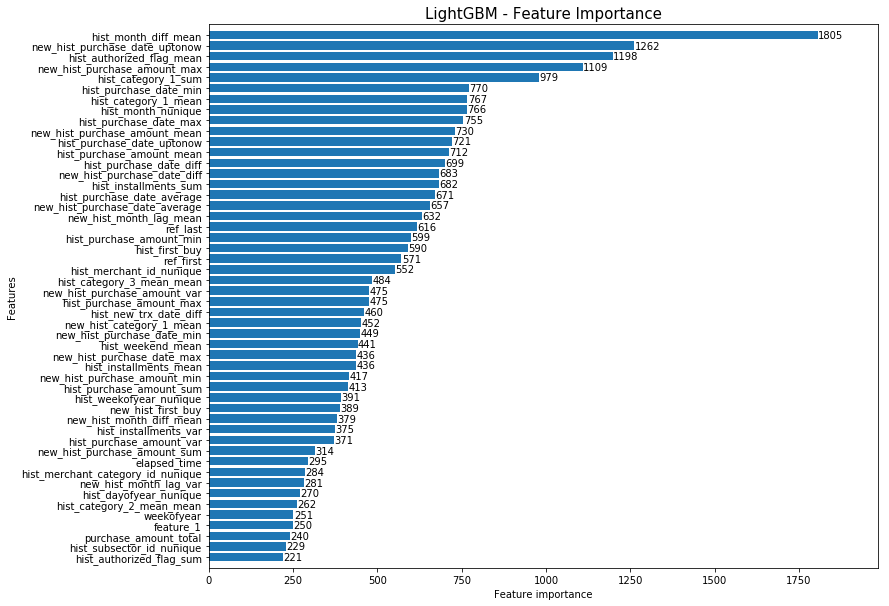

In [19]:
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### With Mean Feature_Importance

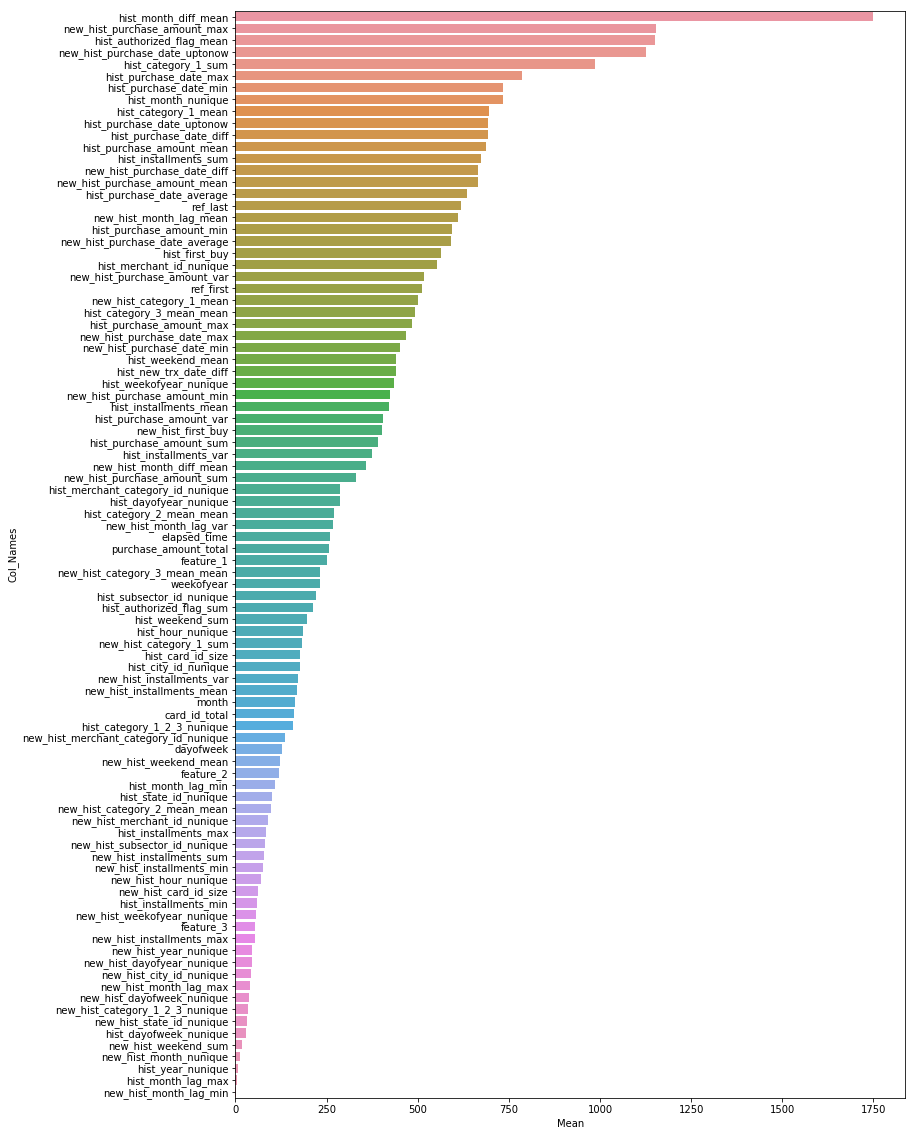

In [28]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,20))
sns.barplot(x="Mean", y="Col_Names", data = feature_imp, orient='h',ax=ax)
plt.show()